# Assignment 1:

1. Take photos of your environment of two or more objects. (at least 100 instances between all objects) 

2. Annotate them on roboflow. 

3. Train a Faster RCNN model using detectron2

4. Train Yolov4/5/6/7/8 (only one of them of choice) the smallest size

5. Evaluate both models based on mAP and speed and size.


# Solution

The 2 objects that I decided to detect are **Dates and Cashews** and there is a story behind that. One day I was watching a movie and I wanted some snacks but I was to lazy to go to the kitchen and get some, so I thought what if there is a robot that can do this for me? life will be much easier. So I decieded to bring the humanity one step closer to staying in the bed while being served by robots and train a model that can detect Dates and Cashews.


# Training a Faster RCNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Mar  4 16:58:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Detectron2 and dependencies

In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-h9nk0sms
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-h9nk0sms
  Resolved https://github.com/facebookresearch/detectron2.git to commit 670b54e376d468958834bce380672d5a23d49922
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

Now is a good time to confirm that we have the right versions of the libraries at our disposal.

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [5]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## Getting the dataset from roboflow

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WJyjEZUoS9AgElDgyPsr")
project = rf.workspace("innopolis-university-vfajb").project("date-cashew")
dataset = project.version(5).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=5e9550012b773eab8b0ce50d4141b86d659be7be2952bd90b626f766927a9927
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: cycler
    Found existing installation: cycler 0.11.0
    Uninstalling cycler-0.11.0:
      Successfully uninstalled cycler-0.11.0


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to date-cashew-5 in coco:: 100%|██████████| 93/93 [00:00<00:00, 1600.77it/s]


### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [7]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [8]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

We can now confirm that our custom dataset was correctly registered using [MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [9]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['date-cashew-train', 'date-cashew-test', 'date-cashew-valid']

### Visualize

Let's take a look at single entry from out train dataset.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



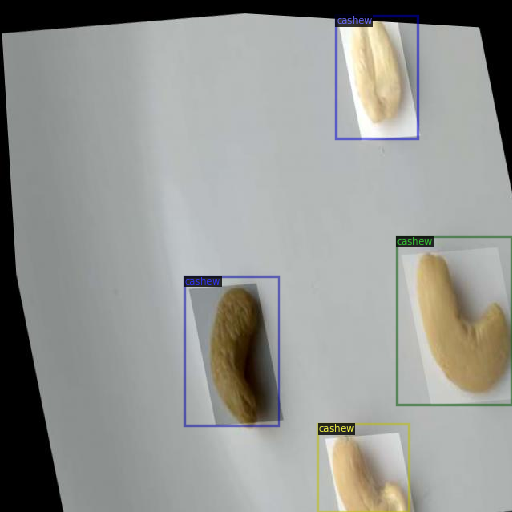

In [10]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

## Train Model Using Custom COCO Format Dataset 

### Configuration

In [11]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 500
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

DRIVE_PATH = r'/content/drive/MyDrive/AML/Faster RCNN'
# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DRIVE_PATH,
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

### Training

In [13]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/04 17:07:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:26, 16.1MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/04 17:08:20 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)


[03/04 17:08:56 d2.utils.events]:  eta: 0:11:37  iter: 19  total_loss: 2.638  loss_cls: 1.487  loss_box_reg: 0.9646  loss_rpn_cls: 0.06738  loss_rpn_loc: 0.03921  time: 1.3857  last_time: 1.5459  data_time: 0.0208  last_data_time: 0.0104   lr: 3.8962e-05  max_mem: 4228M
[03/04 17:09:25 d2.utils.events]:  eta: 0:11:14  iter: 39  total_loss: 2.198  loss_cls: 0.9747  loss_box_reg: 0.9893  loss_rpn_cls: 0.1163  loss_rpn_loc: 0.04211  time: 1.4156  last_time: 1.3385  data_time: 0.0112  last_data_time: 0.0112   lr: 7.8922e-05  max_mem: 4228M
[03/04 17:09:54 d2.utils.events]:  eta: 0:10:46  iter: 59  total_loss: 1.736  loss_cls: 0.6841  loss_box_reg: 0.9576  loss_rpn_cls: 0.02406  loss_rpn_loc: 0.04069  time: 1.4196  last_time: 1.1866  data_time: 0.0117  last_data_time: 0.0288   lr: 0.00011888  max_mem: 4228M
[03/04 17:10:22 d2.utils.events]:  eta: 0:10:15  iter: 79  total_loss: 1.617  loss_cls: 0.5975  loss_box_reg: 0.9427  loss_rpn_cls: 0.008903  loss_rpn_loc: 0.02796  time: 1.4178  last_ti

### Evaluation

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[03/04 17:21:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AML/Faster RCNN/date-cashew/faster_rcnn_X_101_32x8d_FPN_3x/2023-03-04-17-07-34/model_final.pth ...


WARNING [03/04 17:21:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/04 17:21:26 d2.data.datasets.coco]: Loaded 6 images in COCO format from /content/date-cashew-5/valid/_annotations.coco.json
{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 52.6008, 289.0663, 388.6057, 552.8568]], device='cuda:0')), scores: tensor([0.9802], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


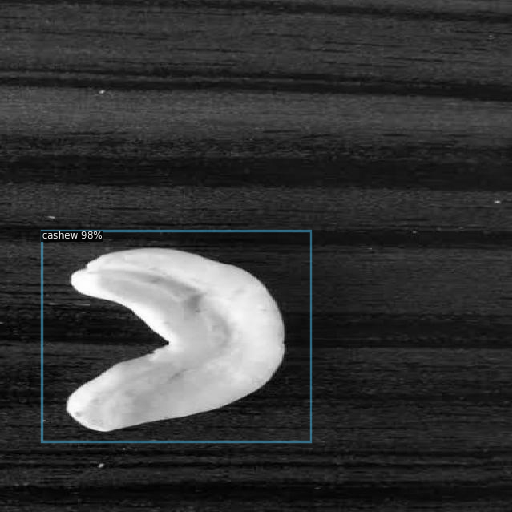

{'instances': Instances(num_instances=12, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[  4.7813, 330.3899, 192.3523, 462.7076],
        [320.3525, 222.4744, 437.3846, 332.6324],
        [280.9078, 335.8508, 385.9829, 411.2999],
        [169.7405, 139.1321, 244.0272, 207.2328],
        [202.5572, 301.1262, 327.5410, 401.1653],
        [  0.0000, 290.5605, 125.2561, 357.8433],
        [116.7619, 221.1046, 194.3325, 286.8597],
        [267.7978, 157.4055, 343.3711, 211.5143],
        [ 82.7387, 264.8908, 188.8287, 319.8688],
        [  0.0000, 357.8708,  47.8565, 440.0141],
        [ 84.4752, 186.4473, 174.4438, 230.2848],
        [227.5216, 208.5614, 285.7184, 259.2509]], device='cuda:0')), scores: tensor([0.9717, 0.9613, 0.9475, 0.9362, 0.9007, 0.8967, 0.8795, 0.8779, 0.8760,
        0.8658, 0.7545, 0.7014], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


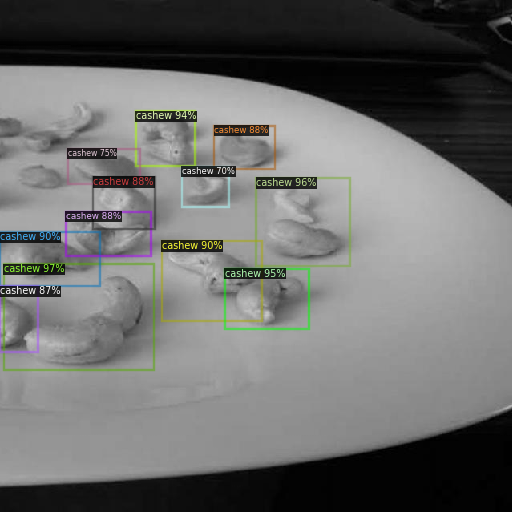

{'instances': Instances(num_instances=10, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[9.9395e+01, 3.1171e+02, 3.0741e+02, 4.5041e+02],
        [6.3934e+01, 2.0246e+02, 2.0141e+02, 3.4383e+02],
        [1.5539e+01, 1.6138e+02, 1.0014e+02, 2.4797e+02],
        [3.1949e+02, 2.4289e+02, 4.5395e+02, 3.6443e+02],
        [0.0000e+00, 3.1890e+02, 4.8800e+01, 4.3061e+02],
        [1.1349e-01, 2.0212e+02, 4.5611e+01, 2.9012e+02],
        [1.1744e+02, 1.1087e+02, 2.8109e+02, 2.6259e+02],
        [0.0000e+00, 1.3636e+02, 8.9639e+01, 1.8644e+02],
        [2.9189e+02, 1.7292e+02, 4.3153e+02, 2.9095e+02],
        [1.1062e+02, 1.1365e+02, 2.4597e+02, 1.9596e+02]], device='cuda:0')), scores: tensor([0.9748, 0.9694, 0.9675, 0.9593, 0.9552, 0.9502, 0.9432, 0.9189, 0.8586,
        0.7187], device='cuda:0'), pred_classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')])}


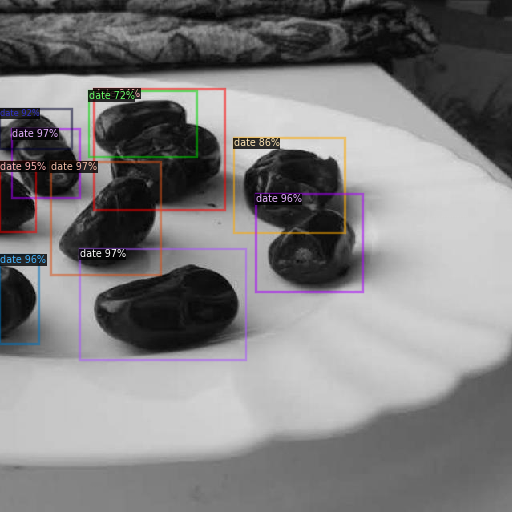

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[  0.0000, 204.1083, 401.9142, 409.0019]], device='cuda:0')), scores: tensor([0.9913], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


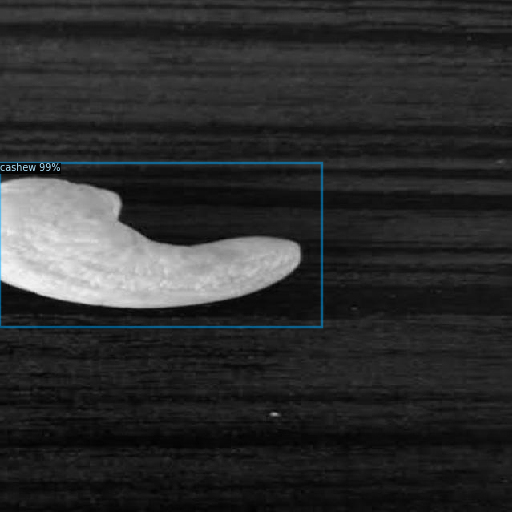

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[135.3657, 367.3089, 447.8445, 498.5782]], device='cuda:0')), scores: tensor([0.9880], device='cuda:0'), pred_classes: tensor([2], device='cuda:0')])}


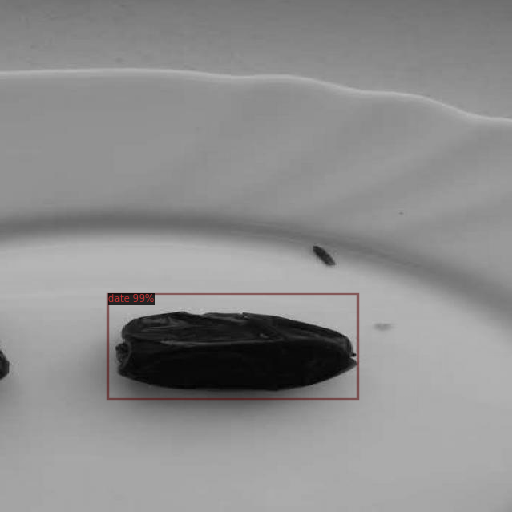

{'instances': Instances(num_instances=18, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[207.7689, 340.0771, 301.8623, 397.2029],
        [346.1403, 386.0420, 432.2326, 435.5765],
        [373.1140, 312.5936, 458.9089, 376.2644],
        [254.3784, 163.8401, 311.4310, 204.8446],
        [ 80.5457, 314.7234, 156.2104, 367.4046],
        [  1.8411, 267.8286,  80.5905, 317.2454],
        [ 87.1582, 230.6506, 141.2515, 265.6615],
        [309.5337, 264.8913, 391.4892, 315.3109],
        [278.1288, 197.0376, 353.5304, 246.0765],
        [ 43.1151, 157.1977, 113.2616, 188.3082],
        [385.3985, 219.6518, 466.5120, 257.1833],
        [ 56.7953, 207.9440, 112.7431, 241.7771],
        [207.0791, 192.1535, 261.8404, 238.6462],
        [449.1777, 266.1428, 517.0903, 311.2200],
        [185.0181, 244.9202, 244.5367, 293.6108],
        [135.5751, 151.2139, 185.9579, 189.4175],
        [196.4637, 140.0218, 239.2585, 175.9189],
        [142.9652, 197.0411, 185.9790, 236.6124

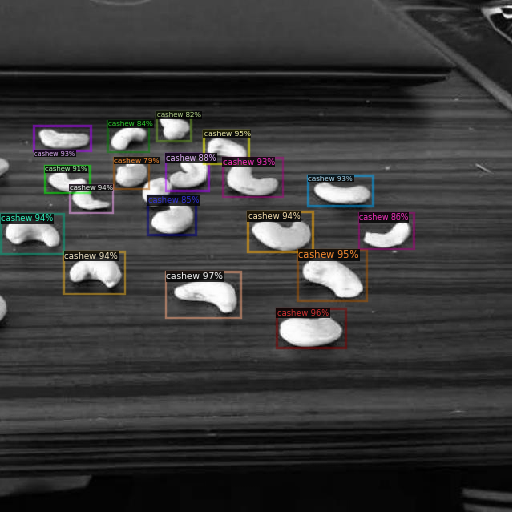

In [20]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)
for d in dataset_valid:

    img = cv2.imread(d['file_name'])
    outputs = predictor(img)
    print(outputs)
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata, 
        scale=0.8, 
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

  

# Testing

In [21]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, cfg, False, output_dir=OUTPUT_DIR_PATH)
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/04 17:21:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AML/Faster RCNN/date-cashew/faster_rcnn_X_101_32x8d_FPN_3x/2023-03-04-17-07-34/model_final.pth ...
WARNING [03/04 17:21:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/04 17:21:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/04 17:21:50 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/date-cashew-5/test/_annotations.coco.json
[03/04 17:21:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/04 17:21:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/04 17:21:50 d2.data.common]: Serializing 4 elements 

OrderedDict([('bbox',
              {'AP': 44.084158415841586,
               'AP50': 81.43564356435643,
               'AP75': 47.44224422442244,
               'APs': nan,
               'APm': 45.0,
               'APl': 44.24092409240924,
               'AP-date-sunflower': nan,
               'AP-cashew': 36.51815181518152,
               'AP-date': 51.650165016501646})])

## Evaluation
The mAP for object detection is the average of the AP calculated for all the classes.

cashew AP = 36.518

date AP = 51.650 

**mAP** = (36.518 + 51.650 ) / 2 = 44.084


**inference time** = 67ms per image

**Size:**: 401Mb



# Training YOLOv8


In [39]:
import os
HOME = r'/content'
print(HOME)

/content


## Install YOLOv8

In [40]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [41]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [42]:
from ultralytics import YOLO

from IPython.display import display, Image

### Importing the data

In [43]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WJyjEZUoS9AgElDgyPsr")
project = rf.workspace("innopolis-university-vfajb").project("date-cashew")
dataset = project.version(5).download("yolov8")

/content/datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to date-cashew-5 in yolov8:: 100%|██████████| 182/182 [00:00<00:00, 932.22it/s]


## Custom Training

In [44]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content
100% 21.5M/21.5M [00:04<00:00, 5.10MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/date-cashew-5/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=Fa

In [45]:
!ls {HOME}/runs/detect/train/

args.yaml					     train_batch0.jpg
confusion_matrix.png				     train_batch1.jpg
events.out.tfevents.1677952533.837f556823eb.16840.0  train_batch2.jpg
F1_curve.png					     train_batch75.jpg
P_curve.png					     train_batch76.jpg
PR_curve.png					     train_batch77.jpg
R_curve.png					     val_batch0_labels.jpg
results.csv					     val_batch0_pred.jpg
results.png					     weights


/content


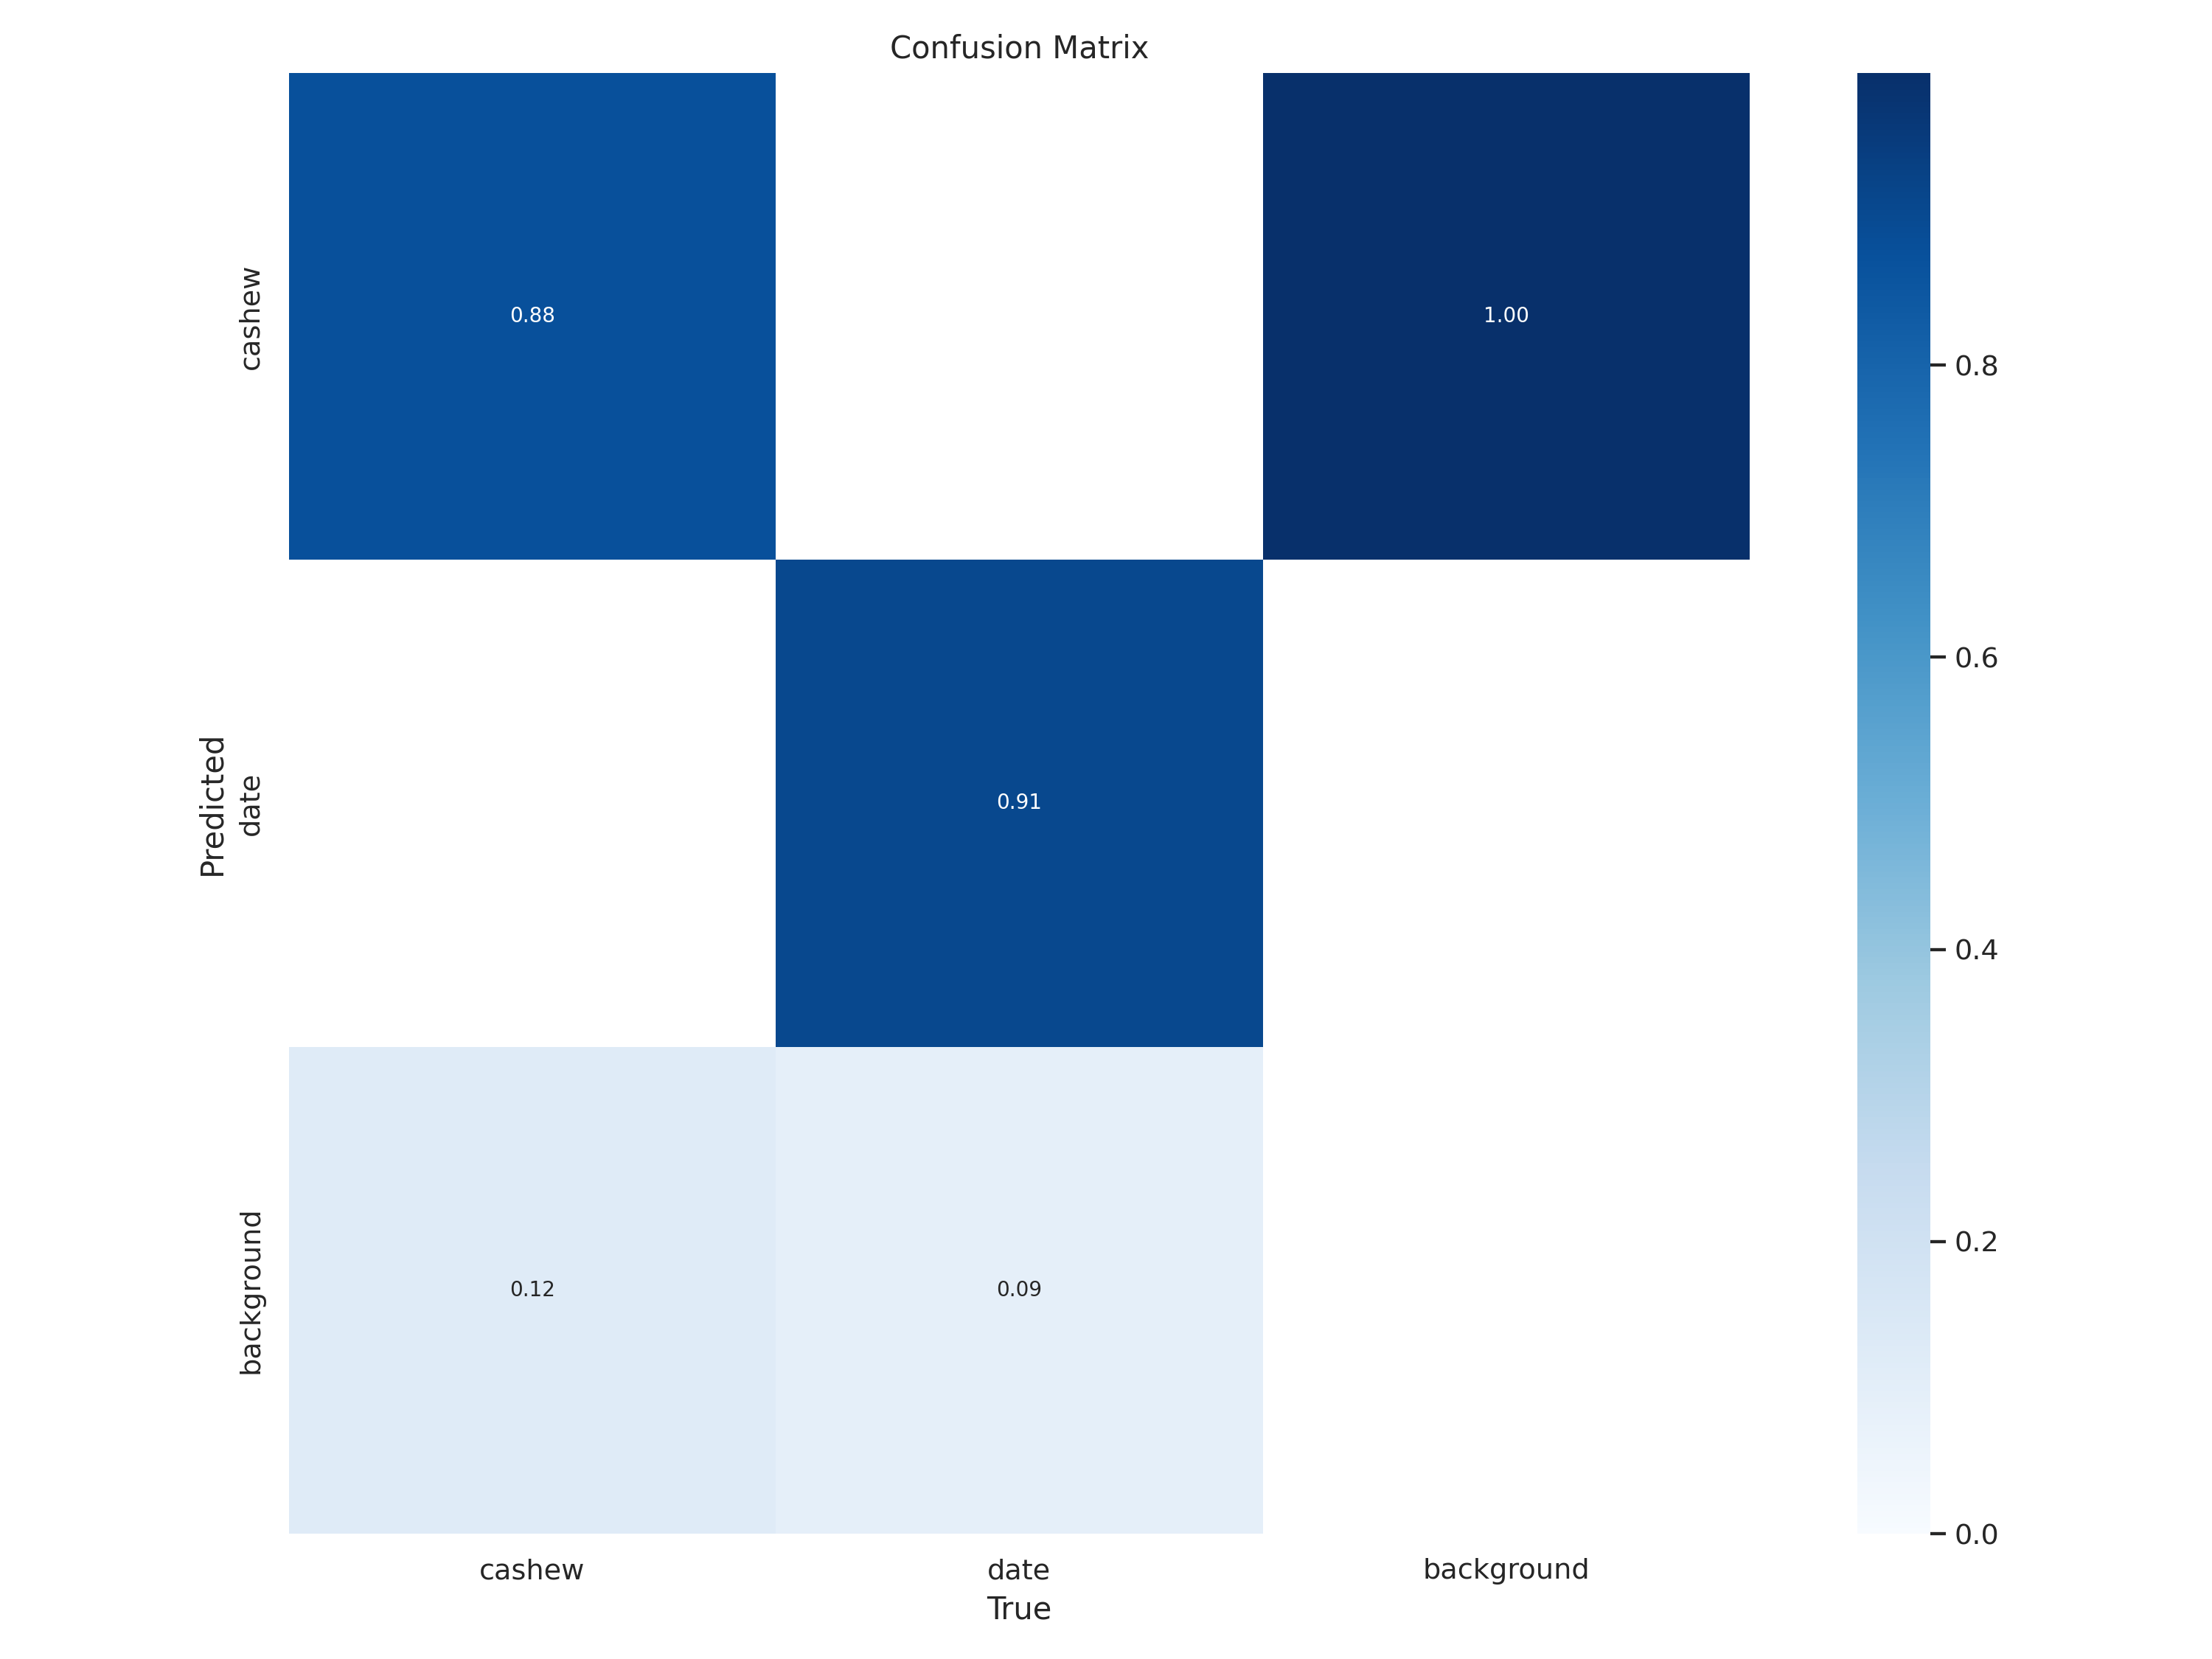

In [46]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


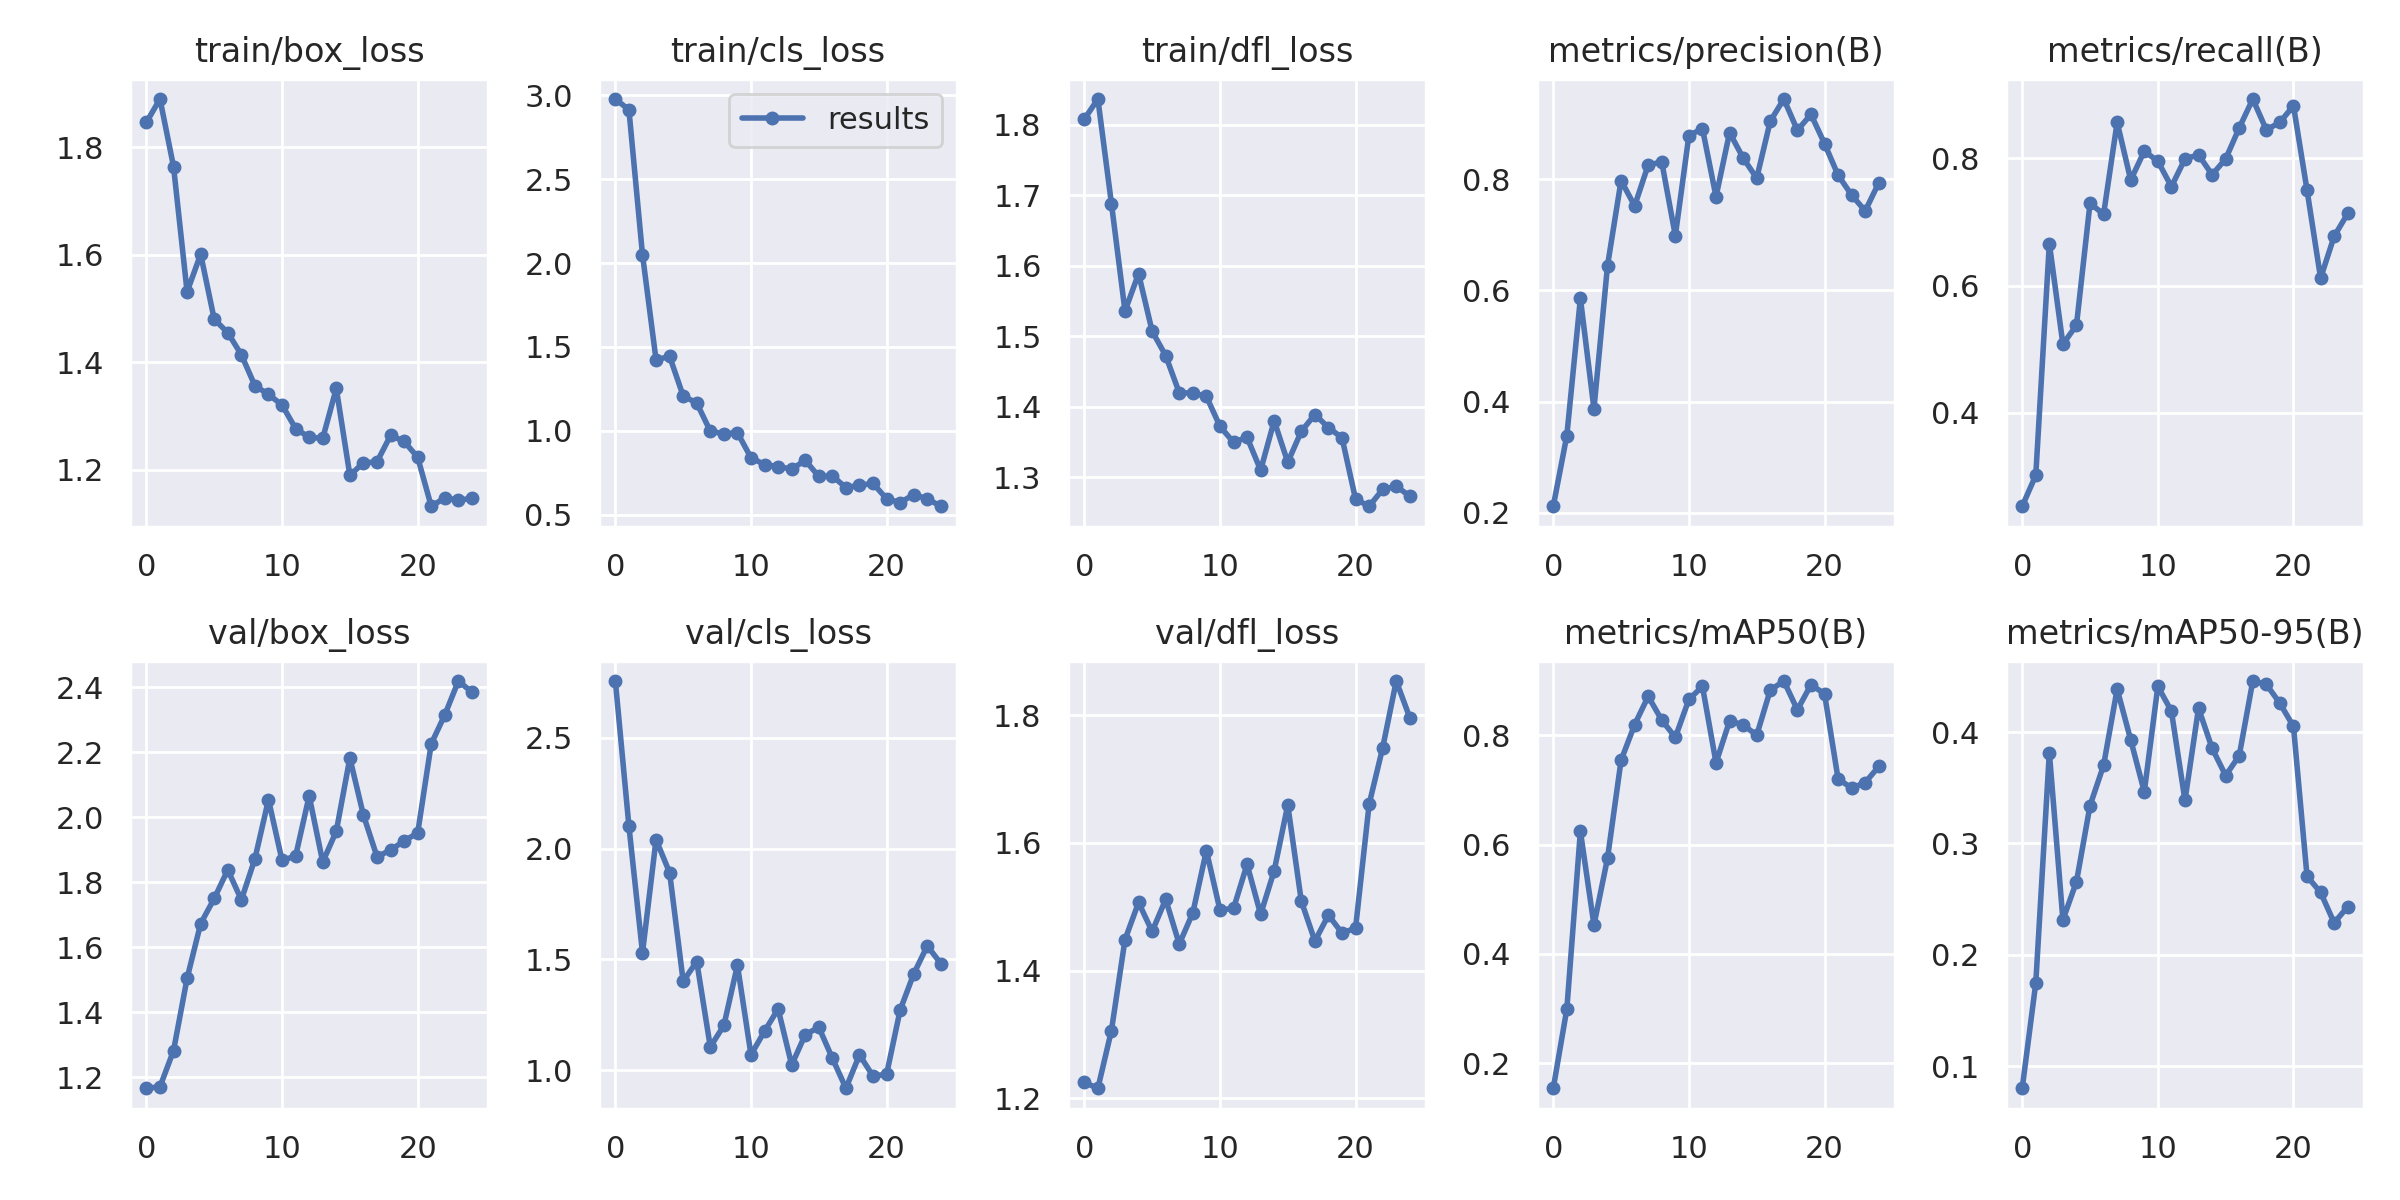

In [47]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


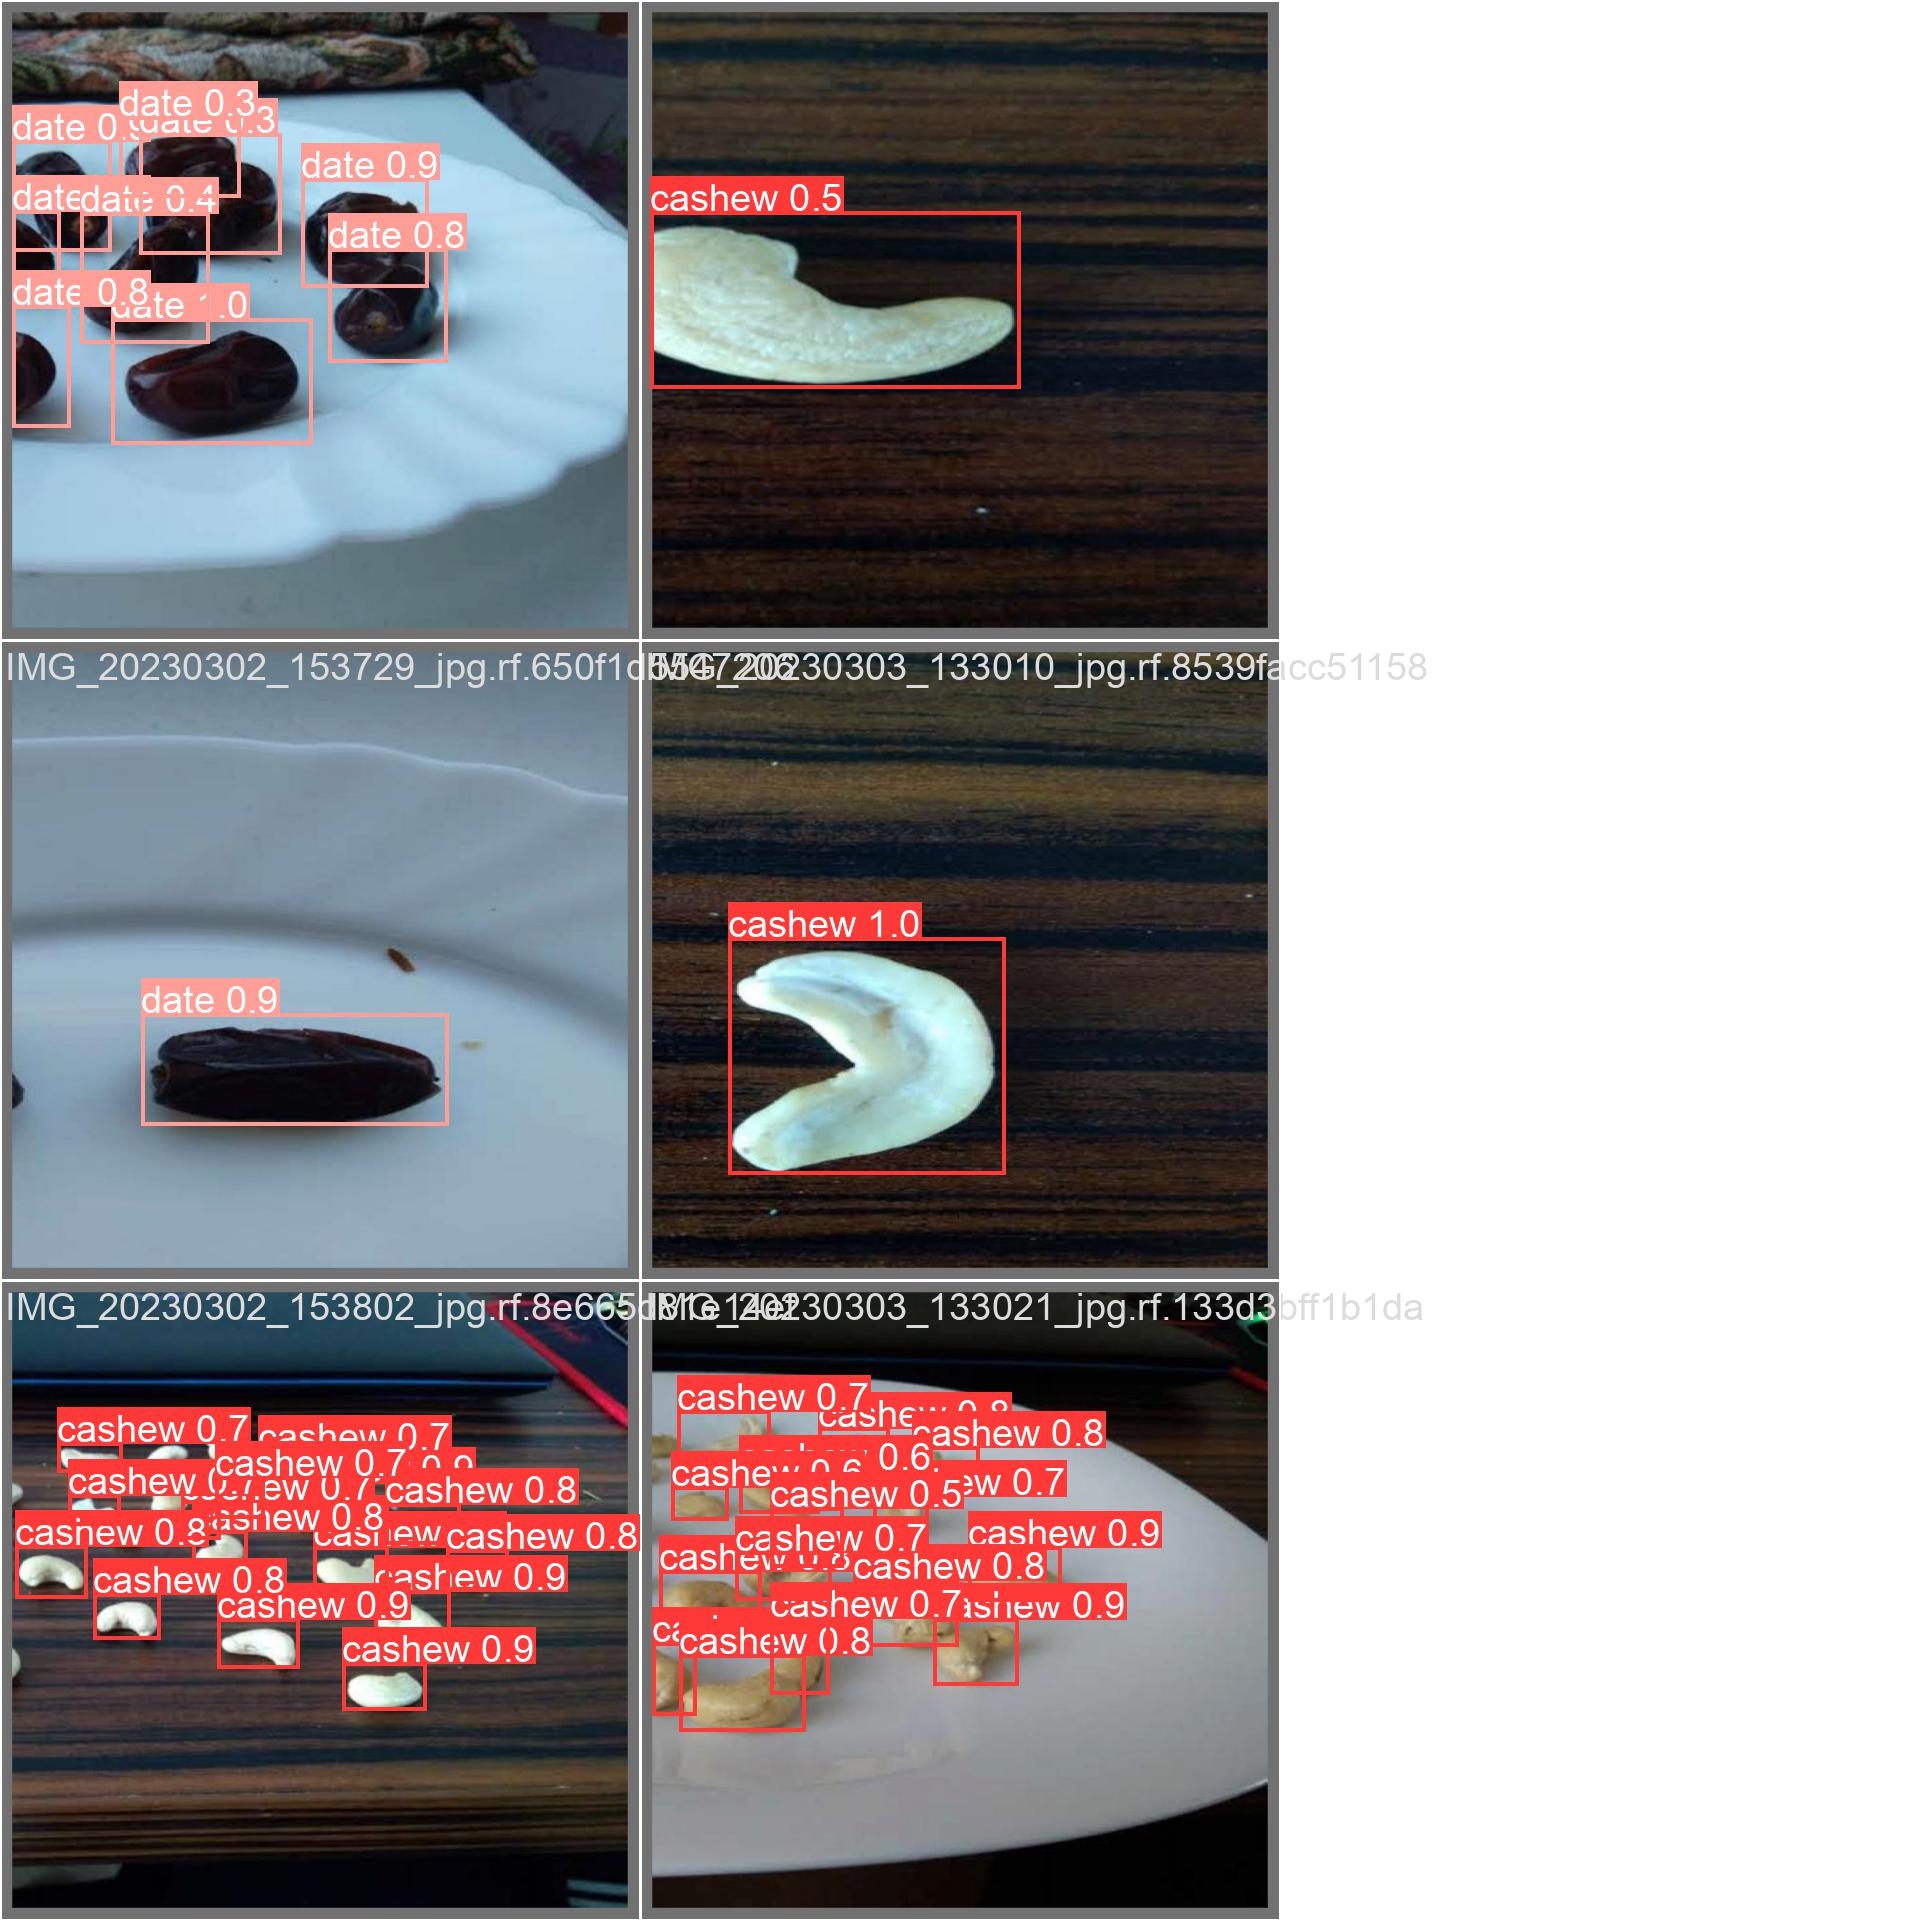

In [48]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [49]:
%cd {HOME}

!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/date-cashew-5/valid/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.00it/s]
                   all          6         52      0.945      0.894      0.899      0.446
                cashew          6         41      0.906      0.878      0.892      0.449
                  date          6         11      0.984      0.909      0.906      0.442
Speed: 0.4ms pre-process, 21.6ms inference, 0.0ms loss, 1.1ms post-process per image


**mAP** = 44.6

**inference time** = 23.1ms per image

**parameters:** 11136374 

**Size:** 21.5Mb

# Evaluation summary

Faster RCNN:

**mAP** = 44.084

**inference time** = 67ms per image

**Size:**: 401Mb

YOLO:

**mAP** = 44.6

**inference time** = 23.1ms per image

**parameters:** 11136374 

**Size:** 21.5Mb
